# **<a>Assignment_2**
**Name :** Karim Gamal Mahmoud Mohamed

**ID : 21kgmm**


> ![](https://machinelearningmastery.com/wp-content/uploads/2021/04/What-Is-Semi-Supervised-Learning.jpg)

> Photo by Paul VanDerWerf, this picture full of beautiful landscapes has absolutely nothing to do with our topic 🧚


> [Source](https://machinelearningmastery.com/what-is-semi-supervised-learning/)

> **In this Assignment**, we would be given a dataset named **MTL-AQA**. You can download and
check the information of this dataset here: [Link](https://github.com/ParitoshParmar/)

> **MTL-AQA. MTL-AQA** contains data related to a task named Action Quality Assessment (AQA). 

>AQA aims to evaluate how well an action performs, i.e., predict score
from a given video. 

> It is a significant problem with applications in many domains,
including healthcare (e.g., evaluate the progress of patients in performing certain
rehabilitation tasks or train the personnel for performing medical procedures) and
sports (e.g., to help athletes improve their performance).


>You are allowed to read the paper associated with this dataset and reuse their code
with references.


> ## <a> Q1)</a> 

> ## Form a semi-supervised AQA task from this data, 

> ## Describe how you would design the experiment setup for evaluating a semi-supervised learning approach on your proposed task, 

> ## Provide a valid solution (e.g., model architecture) for your experiment setup

> ---

> ### <a>**Q1-p1)** </a> In our research approach , if we need to generate a semi-supervised AQA from this data,  we need to remove the labels of a large number of datasets samples that used to evaluate semi-supervised learning algorithms from the existing supervised learning dataset.

> ### I prefer to remove the supervised learning data set sample labels in an approximate ratio of 70% to 80% and leave the rest of the remaining data sample labels.

> ### <a> **Q1-p3)** </a> To provide a model architecture for our experiment setup . We have several architectures that we can use but we will implement **"quasi-co-supervised regression (COREG)"** and **"Pseudo-labels"** , because they are explained in the lecture as well.

> 1. <a>**`Co-Training Semi-Supervised Regression (COREG): `**</a> COREG is a non-parametric co-training style semisupervised regression algorithm, which uses two K-nearest neighbor regressors with different distance metrics to generate the scores for unlabeled videos by estimating the influence of the labeling for unlabeled videos on the labeled videos. We utilize the average of video segment features extracted by I3D as the input of COREG.

> 2. <a>**`Pseudo-labels: `**</a>  In order to adapt to the semisupervised regression, we use the k-nearest neighbor
algorithm to generate the pseudo labels for unlabeled
videos by the distance metric between labeled videos and
unlabeled videos in the embedding space as . We set
the training weight of the unlabeled videos as 0.5 in the
experiment.


> Before knowing our input and output features, let's know a few things about the `AQA dataset`.

> **AQA dataset.** With 1412 samples, it is the largest AQA
dataset to date. This particular dataset focuses only on Diving as it has seen the most usage recently. Data was compiled from 16 different events unlike the single main event
(2012 Olympics Men’s 10m Platform Diving competition)



> 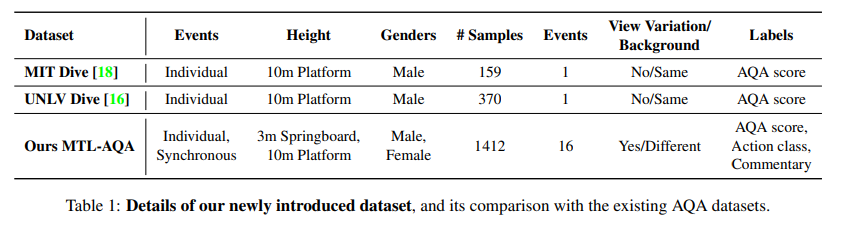



> - <a>`The input features: `</a> it will be the video segment features
extracted by the I3D over the labeled training samples

> - All video frames are center
cropped from original frames and resized into 224 × 224.
And the dimension of each basic video segment feature
extracted by the I3D backbone is 1024.

> 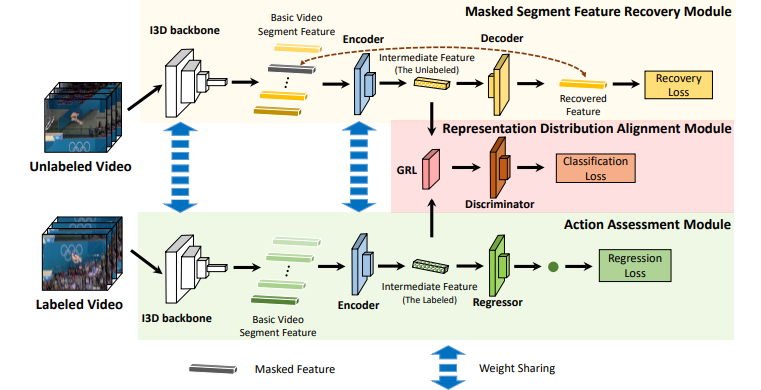

> - <a>`The output: `</a>the prediction of the action scores

> ### <a> **Q1-p2)** </a> To evaluate our approach, we will compare the prediction results for the methods (prediction labels) with the original labels for the dataset.
we will use the mean squared error (MSE) loss.

> 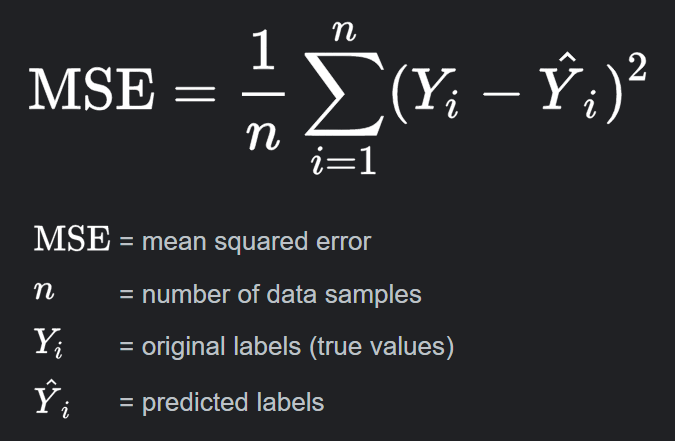

---

> ## <a>**Q2)**</a>  Implement your proposed semi-supervised AQA solution (in a jupyter notebook).

> 


> ### Import needed libraries.

In [ ]:
# import torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import numpy as np # for linear algebra
import sys
import os
import random
import glob
from PIL import Image
import pickle as pkl

import logging
import math

from scipy import stats
from tqdm import tqdm # Instantly make your loops show a smart progress meter
import argparse

> ### Importing Data From Google Drive

In [ ]:
%%capture
# gdown command to download this data
!gdown --folder https://drive.google.com/drive/folders/1J_OO6UNJ27WLpjm6nRwqp9WIq0bUeINY?usp=sharing

In [ ]:
%%capture
# to extract this rar file
!unrar x "/content/Share/MTL-AQA data.rar"

In [ ]:
%%capture
# just run this cell :)
!unrar x "/content/Share/weights.rar"

> Applies a 3D max pooling over an input signal composed of several input planes.

In [ ]:
class MaxPool3dSamePadding(nn.MaxPool3d):

    def compute_pad(self, dim, s):
        if s % self.stride[dim] == 0:
            return max(self.kernel_size[dim] - self.stride[dim], 0)
        else:
            return max(self.kernel_size[dim] - (s % self.stride[dim]), 0)

    def forward(self, x):
        # compute 'same' padding
        (batch, channel, t, h, w) = x.size()
        # print t,h,w
        out_t = np.ceil(float(t) / float(self.stride[0]))
        out_h = np.ceil(float(h) / float(self.stride[1]))
        out_w = np.ceil(float(w) / float(self.stride[2]))
        # print out_t, out_h, out_w
        pad_t = self.compute_pad(0, t)
        pad_h = self.compute_pad(1, h)
        pad_w = self.compute_pad(2, w)

        pad_t_f = pad_t // 2
        pad_t_b = pad_t - pad_t_f
        pad_h_f = pad_h // 2
        pad_h_b = pad_h - pad_h_f
        pad_w_f = pad_w // 2
        pad_w_b = pad_w - pad_w_f

        pad = (pad_w_f, pad_w_b, pad_h_f, pad_h_b, pad_t_f, pad_t_b)

        x = F.pad(x, pad)
        return super(MaxPool3dSamePadding, self).forward(x)

> This implementation defines the model as a custom Module subclass. Whenever you want a model more complex than a simple sequence of existing Modules you will need to define your model this way.

In [ ]:
class Unit3D(nn.Module):

    def __init__(self, in_channels, output_channels,
                 kernel_shape=(1, 1, 1),
                 stride=(1, 1, 1), padding=0,
                 activation_fn=F.relu,
                 use_batch_norm=True, use_bias=False,
                 name='unit_3d'):

        """Initializes Unit3D module."""
        super(Unit3D, self).__init__()

        self._output_channels = output_channels
        self._kernel_shape = kernel_shape
        self._stride = stride
        self._use_batch_norm = use_batch_norm
        self._activation_fn = activation_fn
        self._use_bias = use_bias
        self.name = name
        self.padding = padding

        self.conv3d = nn.Conv3d(in_channels=in_channels, out_channels=self._output_channels,
                                kernel_size=self._kernel_shape, stride=self._stride, padding=0,
                                # we always want padding to be 0 here. We will dynamically pad based on input size in forward function
                                bias=self._use_bias)

        if self._use_batch_norm:
            self.bn = nn.BatchNorm3d(self._output_channels, eps=0.001, momentum=0.01)

In [ ]:
class Unit3D(Unit3D):
    def compute_pad(self, dim, s):
        if s % self._stride[dim] == 0:
            return max(self._kernel_shape[dim] - self._stride[dim], 0)
        else:
            return max(self._kernel_shape[dim] - (s % self._stride[dim]), 0)

> In `forward` method  the execution order specified for it

In [ ]:
class Unit3D(Unit3D):
    def forward(self, x):
        # compute 'same' padding
        (batch, channel, t, h, w) = x.size()
        # print t,h,w
        
        out_t = np.ceil(float(t) / float(self._stride[0]))
        out_h = np.ceil(float(h) / float(self._stride[1]))
        out_w = np.ceil(float(w) / float(self._stride[2]))
        # print out_t, out_h, out_w
        
        pad_t = self.compute_pad(0, t)
        pad_h = self.compute_pad(1, h)
        pad_w = self.compute_pad(2, w)
        # print pad_t, pad_h, pad_w

        pad_t_f = pad_t // 2
        pad_t_b = pad_t - pad_t_f
        pad_h_f = pad_h // 2
        pad_h_b = pad_h - pad_h_f
        pad_w_f = pad_w // 2
        pad_w_b = pad_w - pad_w_f

        pad = (pad_w_f, pad_w_b, pad_h_f, pad_h_b, pad_t_f, pad_t_b)
        # print x.size()
        # print pad
        x = F.pad(x, pad)
        # print x.size()

        x = self.conv3d(x)
        if self._use_batch_norm:
            x = self.bn(x)
        if self._activation_fn is not None:
            x = self._activation_fn(x)
        return x

>  This is the definition of InceptionModule

In [ ]:
class InceptionModule(nn.Module):
    # Structure for stacking multiple convolutions ,that Will be used in InceptionI3d
    def __init__(self, in_channels, out_channels, name):
        super(InceptionModule, self).__init__()

        self.b0 = Unit3D(in_channels=in_channels, output_channels=out_channels[0], kernel_shape=[1, 1, 1], padding=0, name=name + '/Branch_0/Conv3d_0a_1x1')
        self.b1a = Unit3D(in_channels=in_channels, output_channels=out_channels[1], kernel_shape=[1, 1, 1], padding=0, name=name + '/Branch_1/Conv3d_0a_1x1')
        self.b1b = Unit3D(in_channels=out_channels[1], output_channels=out_channels[2], kernel_shape=[3, 3, 3], name=name + '/Branch_1/Conv3d_0b_3x3')
        self.b2a = Unit3D(in_channels=in_channels, output_channels=out_channels[3], kernel_shape=[1, 1, 1], padding=0, name=name + '/Branch_2/Conv3d_0a_1x1')
        self.b2b = Unit3D(in_channels=out_channels[3], output_channels=out_channels[4], kernel_shape=[3, 3, 3], name=name + '/Branch_2/Conv3d_0b_3x3')
        self.b3a = MaxPool3dSamePadding(kernel_size=[3, 3, 3], stride=(1, 1, 1), padding=0)
        self.b3b = Unit3D(in_channels=in_channels, output_channels=out_channels[5], kernel_shape=[1, 1, 1], padding=0, name=name + '/Branch_3/Conv3d_0b_1x1')
        self.name = name

> This is based on the structure of Inception.

In [ ]:
class InceptionModule(InceptionModule):
    # There are four outputs in total, then stack them and output
    def forward(self, x):
        b0 = self.b0(x)
        b1 = self.b1b(self.b1a(x))
        b2 = self.b2b(self.b2a(x))
        b3 = self.b3b(self.b3a(x))
        return torch.cat([b0, b1, b2, b3], dim=1)

> ### Inception-v1 I3D architecture network structure definition

> Note: The three modules defined above are used

> ![](https://raw.githubusercontent.com/InfoX-SEU/DAE-AQA/aeaf81986ee71feb7d87a9f6dd47b4ca3e878821/Fig/structure.png)

In [ ]:
class InceptionI3d(nn.Module):
    """Inception-v1 I3D architecture.
    The model is introduced in:
        Quo Vadis, Action Recognition? A New Model and the Kinetics Dataset
        Joao Carreira, Andrew Zisserman
        https://arxiv.org/pdf/1705.07750v1.pdf.
    See also the Inception architecture, introduced in:
        Going deeper with convolutions
        Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed,
        Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, Andrew Rabinovich.
        http://arxiv.org/pdf/1409.4842v1.pdf.
    """

    # Endpoints of the model in order. During construction, all the endpoints up
    # to a designated `final_endpoint` are returned in a dictionary as the
    # second return value.
    VALID_ENDPOINTS = (
        'Conv3d_1a_7x7', 'MaxPool3d_2a_3x3',
        'Conv3d_2b_1x1', 'Conv3d_2c_3x3',
        'MaxPool3d_3a_3x3', 'Mixed_3b',
        'Mixed_3c', 'MaxPool3d_4a_3x3',
        'Mixed_4b', 'Mixed_4c',
        'Mixed_4d', 'Mixed_4e',
        'Mixed_4f', 'MaxPool3d_5a_2x2',
        'Mixed_5b', 'Mixed_5c',
        'Logits', 'Predictions', )


In [ ]:
class InceptionI3d(InceptionI3d):
    def __init__(self, num_classes=157, spatial_squeeze=True, final_endpoint='Logits', name='inception_i3d', in_channels=3, dropout_keep_prob=0.5):
        """Initializes I3D model instance.
        Args:
          num_classes: The number of outputs in the logit layer (default 400, which
              matches the Kinetics dataset).
          spatial_squeeze: Whether to squeeze the spatial dimensions for the logits
              before returning (default True).
          final_endpoint: The model contains many possible endpoints.
              `final_endpoint` specifies the last endpoint for the model to be built
              up to. In addition to the output at `final_endpoint`, all the outputs
              at endpoints up to `final_endpoint` will also be returned, in a
              dictionary. `final_endpoint` must be one of
              InceptionI3d.VALID_ENDPOINTS (default 'Logits').
          name: A string (optional). The name of this module.
        Raises:
          ValueError: if `final_endpoint` is not recognized.
        """

        if final_endpoint not in self.VALID_ENDPOINTS:
            raise ValueError('Unknown final endpoint %s' % final_endpoint)

        super(InceptionI3d, self).__init__()
        self._num_classes = num_classes
        self._spatial_squeeze = spatial_squeeze
        self._final_endpoint = final_endpoint
        self.logits = None

        if self._final_endpoint not in self.VALID_ENDPOINTS:
            raise ValueError('Unknown final endpoint %s' % self._final_endpoint)

        self.end_points = {}
        end_point = 'Conv3d_1a_7x7'
        self.end_points[end_point] = Unit3D(in_channels=in_channels, output_channels=64, kernel_shape=[7, 7, 7], stride=(2, 2, 2), padding=(3, 3, 3), name=name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'MaxPool3d_2a_3x3'
        self.end_points[end_point] = MaxPool3dSamePadding(kernel_size=[1, 3, 3], stride=(1, 2, 2), padding=0)
        if self._final_endpoint == end_point: return

        end_point = 'Conv3d_2b_1x1'
        self.end_points[end_point] = Unit3D(in_channels=64, output_channels=64, kernel_shape=[1, 1, 1], padding=0, name=name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Conv3d_2c_3x3'
        self.end_points[end_point] = Unit3D(in_channels=64, output_channels=192, kernel_shape=[3, 3, 3], padding=1, name=name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'MaxPool3d_3a_3x3'
        self.end_points[end_point] = MaxPool3dSamePadding(kernel_size=[1, 3, 3], stride=(1, 2, 2), padding=0)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_3b'
        self.end_points[end_point] = InceptionModule(192, [64, 96, 128, 16, 32, 32], name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_3c'
        self.end_points[end_point] = InceptionModule(256, [128, 128, 192, 32, 96, 64], name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'MaxPool3d_4a_3x3'
        self.end_points[end_point] = MaxPool3dSamePadding(kernel_size=[3, 3, 3], stride=(2, 2, 2),
                                                          padding=0)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4b'
        self.end_points[end_point] = InceptionModule(128 + 192 + 96 + 64, [192, 96, 208, 16, 48, 64], name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4c'
        self.end_points[end_point] = InceptionModule(192 + 208 + 48 + 64, [160, 112, 224, 24, 64, 64], name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4d'
        self.end_points[end_point] = InceptionModule(160 + 224 + 64 + 64, [128, 128, 256, 24, 64, 64], name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4e'
        self.end_points[end_point] = InceptionModule(128 + 256 + 64 + 64, [112, 144, 288, 32, 64, 64], name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4f'
        self.end_points[end_point] = InceptionModule(112 + 288 + 64 + 64, [256, 160, 320, 32, 128, 128],
                                                     name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'MaxPool3d_5a_2x2'
        self.end_points[end_point] = MaxPool3dSamePadding(kernel_size=[2, 2, 2], stride=(2, 2, 2),
                                                          padding=0)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_5b'
        self.end_points[end_point] = InceptionModule(256 + 320 + 128 + 128, [256, 160, 320, 32, 128, 128],
                                                     name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_5c'
        self.end_points[end_point] = InceptionModule(256 + 320 + 128 + 128, [384, 192, 384, 48, 128, 128],
                                                     name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Logits'
        self.avg_pool = nn.AvgPool3d(kernel_size=[2, 7, 7],
                                     stride=(1, 1, 1))
        self.dropout = nn.Dropout(dropout_keep_prob)
        self.logits = Unit3D(in_channels=384 + 384 + 128 + 128, output_channels=self._num_classes, kernel_shape=[1, 1, 1], padding=0, activation_fn=None, use_batch_norm=False, use_bias=True, name='logits')

        self.build()

> When training our own dataset, we can use `replace_logits` to define the number of categories in your own dataset

In [ ]:
class InceptionI3d(InceptionI3d):

    def replace_logits(self, num_classes):
        self._num_classes = num_classes
        self.logits = Unit3D(in_channels=384 + 384 + 128 + 128, output_channels=self._num_classes, kernel_shape=[1, 1, 1], padding=0, activation_fn=None, use_batch_norm=False, use_bias=True, name='logits')


     # In the above initialization function, we have already used the
     # Modules are all defined in the end_points dictionary
     # The purpose of this function is to add all these modules to
     # module inside to facilitate subsequent calls
    def build(self):
        for k in self.end_points.keys():
            self.add_module(k, self.end_points[k])

> ### Definition of the overall network forward propagation function

In [ ]:
class InceptionI3d(InceptionI3d):
    def forward(self, x):
        
        # Calls to previously defined modules
        # use _modules to work with dataparallel
        for end_point in self.VALID_ENDPOINTS:
            if end_point in self.end_points:
                x = self._modules[end_point](x)  # use _modules to work with dataparallel

        # After passing through all of these modules abovementioned
        # 3d average pooling -> dropout -> logits (3D convolution block)
        x = self.avg_pool(x)


        # If there is space compression, the compression dimension operation will be performed
        # First compress in the fourth dimension, then compress again
        # Compression will only work if the compressed dimension value is 1!
        if self._spatial_squeeze:
            logits = x.squeeze(3).squeeze(3)
        # logits is batch X time X classes, which is what we want to work with
        return logits


    # Extract only image features, and then pass a final layer of 3d average pooling
    # get the final feature image
    def extract_features(self, x):
        for end_point in self.VALID_ENDPOINTS:
            if end_point in self.end_points:
                x = self._modules[end_point](x)
        return self.avg_pool(x)

In [ ]:
class DAE(nn.Module):
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(1024, 256)
        self.fch = nn.Linear(256, 128)
        self.fc2_mean = nn.Linear(128, 1)
        self.fc2_logvar = nn.Linear(128, 1)

    def encode(self, x):
        h0 = F.relu(self.fc1(x))
        h1 = F.relu(self.fch(h0))
        return self.fc2_mean(h1), self.fc2_logvar(h1)

    def reparametrization(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrization(mu, logvar)
        return z, mu, logvar

In [ ]:
Data_frame = './data/frames' # the location of the data
Data_info = './data/info'
C, H, W = 3, 224, 224   # input data dims;
input_resize = 455, 256   # image resizing dims;
num_frames = 103   # num of frames in a single video
segment_points = [0, 10, 20, 30, 40, 50, 60, 70, 80, 87]   # beginning frames of the 10 segments
alpha,beta=0.6,0.4

In [ ]:
def load_image_train(image_path, hori_flip, transform=None):
    image = Image.open(image_path)
    size = input_resize
    interpolator_idx = random.randint(0, 3)
    interpolators = [Image.NEAREST, Image.BILINEAR, Image.BICUBIC, Image.LANCZOS]
    interpolator = interpolators[interpolator_idx]
    image = image.resize(size, interpolator)
    if hori_flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

In [ ]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    size = input_resize
    interpolator_idx = random.randint(0, 3)
    interpolators = [Image.NEAREST, Image.BILINEAR, Image.BICUBIC, Image.LANCZOS]
    interpolator = interpolators[interpolator_idx]
    image = image.resize(size, interpolator)
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

In [ ]:
class VideoDataset(Dataset):
    def __init__(self, mode, args):
        super(VideoDataset, self).__init__()
        self.mode = mode  # train or test
        self.args = args
        self.annotations = pkl.load(open(os.path.join(Data_info, 'augmented_final_annotations_dict.pkl'), 'rb'))
        self.keys = pkl.load(open(os.path.join(Data_info, f'{self.mode}_split_0.pkl'), 'rb'))

    def get_imgs(self, key):
        transform = transforms.Compose([transforms.CenterCrop(H), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


        print('get_img : ', key[0], '___', key[1])
        image_list = sorted((glob.glob(os.path.join(Data_frame, str('{:02d}_{:02d}'.format(key[0], key[1])), '*.jpg'))))
        sample_range = np.arange(0, num_frames)
        # temporal augmentation
        if self.mode == 'train':
            temporal_aug_shift = random.randint(0, self.args.temporal_aug)
            sample_range += temporal_aug_shift
        # spatial augmentation
        if self.mode == 'train':
            hori_flip = random.randint(0, 1)
        images = torch.zeros(num_frames, C, H, W)
        for j, i in enumerate(sample_range):
            if self.mode == 'train':
                images[j] = load_image_train(image_list[i], hori_flip, transform)
            if self.mode == 'test':
                images[j] = load_image(image_list[i], transform)
        return images

    def __getitem__(self, ix):
        key = self.keys[ix]
        data = {}
        data['video'] = self.get_imgs(key)
        data['final_score'] = self.annotations.get(key).get('final_score')
        data['difficulty'] = self.annotations.get(key).get('difficulty')
        data['judge_scores'] = self.annotations.get(key).get('judge_scores')
        return data

    def __len__(self):
        sample_pool = len(self.keys)
        return sample_pool

In [ ]:
def get_dataloaders(args):
    dataloaders = {}
    dataloaders['train'] = torch.utils.data.DataLoader(VideoDataset('train', args), batch_size=args.train_batch_size, num_workers=args.num_workers, shuffle=True, pin_memory=True)
    dataloaders['test'] = torch.utils.data.DataLoader(VideoDataset('test', args), batch_size=args.test_batch_size, num_workers=args.num_workers, shuffle=False, pin_memory=True)
    return dataloaders

In [ ]:
def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--log_info', type=str, help='info that will be displayed when logging', default='DAE')
    parser.add_argument('--lr', type=float, help='learning rate', default=1e-4)
    parser.add_argument('--weight_decay',type=float,help='L2 weight decay', default=1e-5)
    parser.add_argument('--temporal_aug',type=int,help='the maximum of random temporal shift, ranges from 0 to 6',default=6)


    parser.add_argument('--num_workers',type=int,help='number of subprocesses for dataloader',default=16)
    parser.add_argument('--gpu',type=str,help='id of gpu device(s) to be used',default='0')
    parser.add_argument('--train_batch_size',type=int,help='batch size for training phase',default=8)
    parser.add_argument('--test_batch_size',type=int,help='batch size for test phase',default=32)
    parser.add_argument('--num_epochs',type=int,help='number of training epochs',default=100)

    return parser

In [ ]:
def get_logger(filepath, log_info):
    logger = logging.getLogger(filepath)
    logger.setLevel(logging.INFO)
    fh = logging.FileHandler(filepath)
    fh.setLevel(logging.INFO)
    logger.addHandler(fh)
    logger.info('-' * 30 + log_info + '-' * 30)
    return logger


def log_and_print(logger, msg):
    logger.info(msg)
    print(msg)

def loss_function(sigma, x, mu):
    MSE_loss = nn.MSELoss(reduction='sum')
    rec_loss = alpha/((sigma**2)*MSE_loss(x, mu))
    sup_loss = beta*math.log(sigma**2)
    return rec_loss+sup_loss

In [ ]:
sys.path.append('../')
torch.backends.cudnn.enabled = True
i3d_pretrained_path = '/content/weights/rgb_i3d_pretrained.pt'
feature_dim = 1024
epoch_best = 0
rho_best = 0.9

In [ ]:
args = get_parser().parse_known_args()[0]

if not os.path.exists('./exp'):
    os.mkdir('./exp')
if not os.path.exists('./ckpts'):
    os.mkdir('./ckpts')

base_logger = get_logger(f'exp/DAE.log', args.log_info)

os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
i3d = InceptionI3d().cuda()
i3d.load_state_dict(torch.load(i3d_pretrained_path))

dae = DAE().cuda()
dataloaders = get_dataloaders(args)

optimizer = torch.optim.Adam([*i3d.parameters()] + [*dae.parameters()], lr=args.lr, weight_decay=args.weight_decay)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for epoch in range(args.num_epochs):
    log_and_print(base_logger, f'Epoch: {epoch}')

    for split in ['train', 'test']:
        true_scores = []
        pred_scores = []
        sigma = []

        if split == 'train':
            i3d.eval()
            dae.train()
            torch.set_grad_enabled(True)
        else:
            i3d.eval()
            dae.eval()
            torch.set_grad_enabled(False)

        for data in tqdm(dataloaders[split]):
            true_scores.extend(data['final_score'].numpy())
            videos = data['video'].cuda()
            videos.transpose_(1, 2)  # N, C, T, H, W

            batch_size, C, frames, H, W = videos.shape
            clip_feats = torch.empty(batch_size, 10, feature_dim).cuda()
            for i in range(9):
                clip_feats[:, i] = i3d(videos[:, :, 10 * i:10 * i + 16, :, :]).squeeze(2)
            clip_feats[:, 9] = i3d(videos[:, :, -16:, :, :]).squeeze(2)

            preds, mu, sigmas = dae(clip_feats.mean(1))
            preds = preds.view(-1)
            sigmas = sigmas.view(-1)
            mu = mu.view(-1)               
            pred_scores.extend([i.item() for i in preds])
            sigma.extend([i.item() for i in sigmas])

            if split == 'train':
                loss = loss_function(sigma, data['final_score'].float().cuda(), mu)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        rho, p = stats.spearmanr(pred_scores, true_scores)

        log_and_print(base_logger, f'{split} correlation: {rho}')

    if rho > rho_best:
        rho_best = rho
        epoch_best = epoch
        log_and_print(base_logger, '##### New best correlation #####')
        path = 'ckpts/' + str(rho) + '.pt'
        torch.save({'epoch': epoch,
                        'i3d': i3d.state_dict(),
                        'dae': dae.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'rho_best': rho_best}, path)

Epoch: 0


  0%|          | 0/133 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


get_img :  10 ___ 30
get_img :  17 ___ 19
get_img :  1 ___ 6
get_img :  18 ___ 18
get_img :  22 ___ 37
get_img :  22 ___ 29
get_img :  5 ___ 47
get_img :  1 ___ 133
get_img :  2 ___ 19
get_img :  26 ___ 80
get_img :  22 ___ 18
get_img :  1 ___ 128
get_img :  10 ___ 33
get_img :  22 ___ 33
get_img :  4 ___ 74
get_img :  2 ___ 25
get_img :  2 ___ 88
get_img :  14 ___ 40
get_img :  18 ___ 45
get_img :  7 ___ 66
get_img :  1 ___ 54
get_img :  18 ___ 32
get_img :  7 ___ 87
get_img :  4 ___ 123
get_img :  4 ___ 56
get_img :  18 ___ 1
get_img :  18 ___ 58
get_img :  3 ___ 53
get_img :  2 ___ 69
get_img :  17 ___ 163
get_img :  1 ___ 16
get_img :  18 ___ 25
get_img :  6 ___ 14
get_img :  4 ___ 9
get_img :  6 ___ 39
get_img :  9 ___ 81
get_img :  5 ___ 43
get_img :  1 ___ 20
get_img :  14 ___ 4
get_img :  26 ___ 60
get_img :  7 ___ 56
get_img :  14 ___ 62
get_img :  26 ___ 32
get_img :  6 ___ 25
get_img :  7 ___ 69
get_img :  1 ___ 44
get_img :  14 ___ 66
get_img :  14 ___ 31
get_img :  10 ___ 

  0%|          | 0/133 [01:23<?, ?it/s]


RuntimeError: ignored

get_img :  14 ___ 43
get_img :  2 ___ 21
get_img :  9 ___ 58
get_img :  18 ___ 41
get_img :  7 ___ 30
get_img :  9 ___ 38
get_img :  2 ___ 2
get_img :  5 ___ 58


> I've always had the problem of small RAM size using Google Colab because the data is too big, even when I change the size of the input image, it contradicts with the size of the kernel used in the model, and even when i change it, Another problem appears to me.

> But I am putting this code with its error even if there is any future work on this project

> 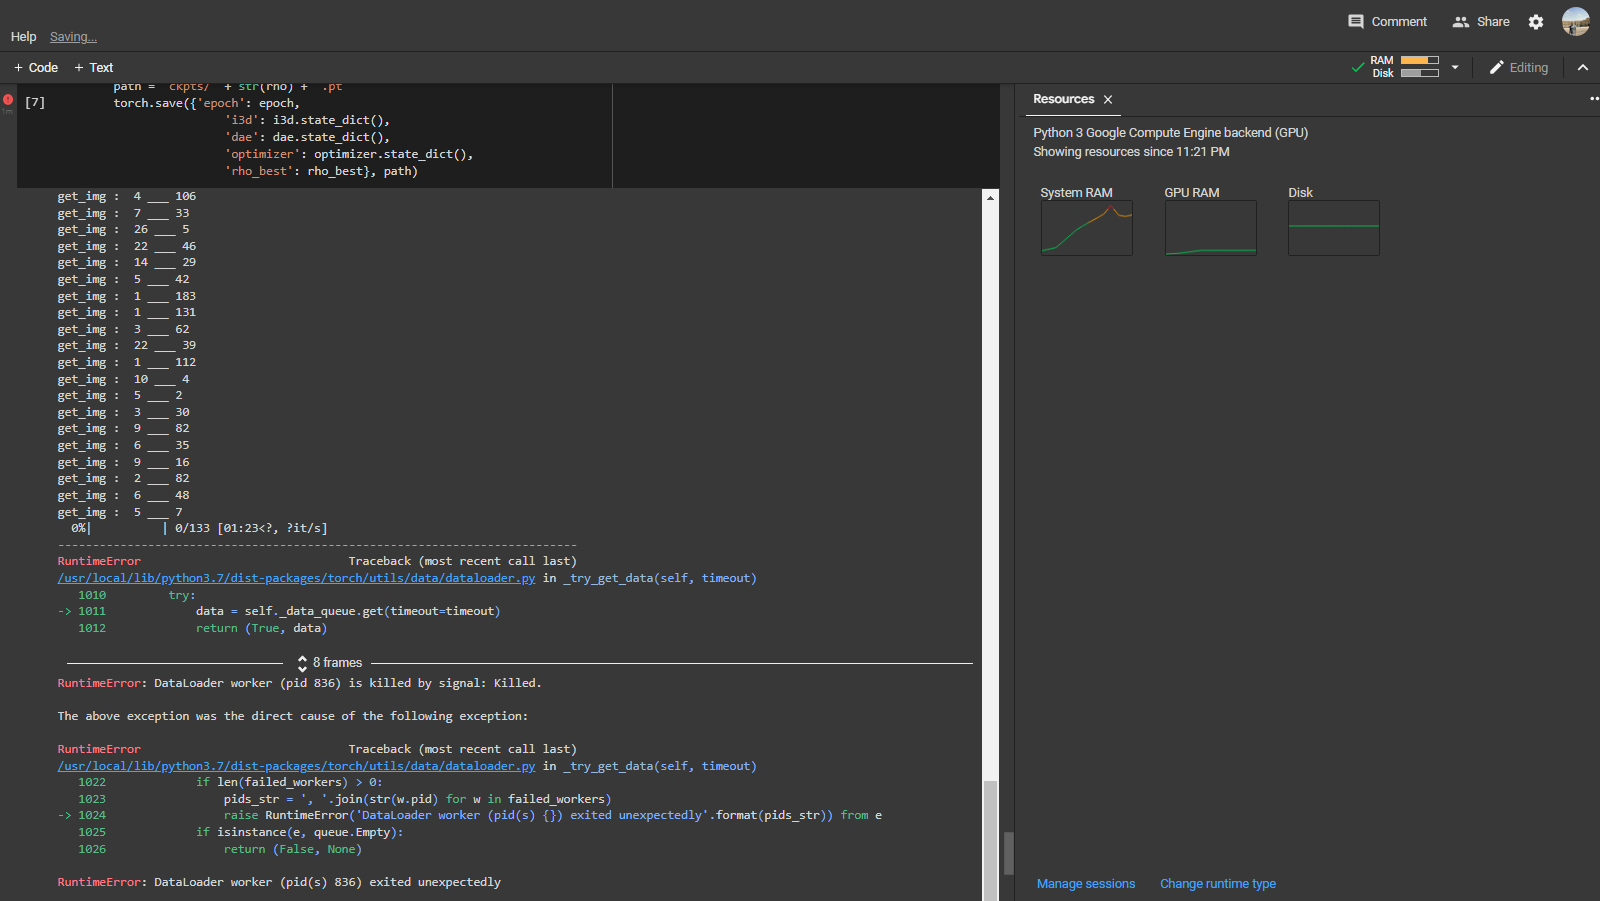

> ## <a> Q3)</a> Read the paper titled “What and How Well You Performed? A Multitask Learning Approach to Action Quality Assessment”, summarize their paper by answering


> ### <a>1.</a> How they form a multi-task learning task from the given dataset? 

> ### <a>2.</a> Besides their proposed multi-task learning problem, do you think other multi-task problems can be formed from the AQA context? Give at least one example. 

> ### <a>3.</a> Provide another application that can benefit from their multi-task learning approach.

> ---

> ### <a>**Q3-1)**</a>  How they form a multi-task learning task from the given dataset?

> Before we know how to form a multi-task learning task, we need to know the meaning of MTL at first.

> In MTL, a model is learnt such that it is suitable for serving more than one task. The tasks
are generally related in nature. Since the tasks are related not completely identical, a part of
the network is shared/common, which branches into heads which are specific to each individual
task. The network is then trained end-to-end using the loss, which is a sum of losses pertaining
to all the tasks. The common network body learns richer features, which can explain all the
tasks.

> ![](https://player.slideplayer.com/102/17502578/slides/slide_6.jpg)

> ### <a> Multitask Approach to AQA :

> <a>`Task selection :`</a> As we noted before, since the AQA is a function of what action was performed, and how well that was performed, our choice of auxiliary tasks (our main task is the
prediction of action quality score) becomes very natural. In order to characterize action, we
consider detailed action recognition as an auxiliary task, which would be responsible for the
what action part. Generating a verbal commentary that describes good and bad points of the
performance becomes an auxiliary task that handles the how well part.

> <a>`Formalization :`</a> in the following, we formalize the problem settings, and objective functions.

> <a> **AQA** </a> is a regression problem, therefore, AQA branch produces sum of Euclidean loss and L1
loss. We found that using L1 loss in addition to L2 loss yields better results.

> <a>**Factorized Action Recognition,**</a> we mean detailed dive recognition in particular. A dive, as
explained in detail in next section, can be broken down into five components. Detailed dive
identification refers to identifying each one of these five components. Detailed adive classification branch produces five cross-entropy losses.


> <a>**Commentary Generation**</a> is a captioning task. So, commentary generation branch produces negative log-likelihood loss.

> The overall loss is a sum of three losses described above.

> ![](https://player.slideplayer.com/102/17502578/slides/slide_10.jpg)

> ![](https://miro.medium.com/max/1400/1*tKIBWweA0be3uamCEC4PUA.png)



> Spatiotemporal features learnt using `3D CNN’s` capture appearance and salient motion
patterns, which make them best candidate for AQA. However, `3D CNN’s` is more suitable for
small length clips than for long videos. So, we use `3D CNN’s` to compute spatiotemporal features
for small clips, and then aggregate those to get whole video-level features in the following two
ways. As discussed previously, `MTL` architectures have a common body and task-specific heads.



> <A>`1. Averaging as aggregation (C3D-AVG):`</a> Throughout the action, an athlete can be
considered as collecting (or losing) points. This operation is an addition operation of
points. Addition is a linear operation. A good metric to evaluate if learnt features are
good, is that linear operations on those features become meaningful. So, we propose to
use addition of clip-level features to obtain video-level features. Doing so would help
the network learn good features. Since the captioning is sequence to sequence task and
ordering matters, LSTM is used on top of clip-level features.

> ![](https://player.slideplayer.com/102/17502578/slides/slide_8.jpg)

> ![](https://player.slideplayer.com/102/17502578/slides/slide_9.jpg)




> <a>`2. Multiscale Context Aggregation with Dilated Convolutions (MSCADC):`</a> In
this architecture, we downsample the action sequence from 96 frames to 16 frames by
dropping frames. This way the need to aggregate clip-level features is eliminated. Inspired by the performance of the architecture used by Nibali et al. on the task of
Diving classification, we adopt their architecture for our case. The backbone is based
on C3D architecture, and in addition, incorporates dilated convolutions and batch
normalization. We also use a separate context net for each task-specific head. This
architecture is fully convolutional – has lesser parameters, which allows to increase the
spatial resolution of the input.


> ![](https://player.slideplayer.com/102/17502578/slides/slide_11.jpg)


> [Source](https://slideplayer.com/slide/17502578/)





> ### <a>**Q3-2)**</a> Besides their proposed multi-task learning problem, do you think other multi-task problems can be formed from the AQA context? Give at least one example.

> Yes, Such as:

> *   <a>`Body position:`</a> 
  *   Athletes are required to perform routines which consist of, for example,
twisting and somersaulting in air.
*   <a>`Splash:`</a> 
  *   In diving, water splash made when the athlete enters water is another factor in determining the final score.
*   <a>`Landing:`</a> 
  *  In sports like Gymnastics, Skiing, and Snowboarding, equivalent of splash is
landing on the mat or ground.

> And we can also detect the height for each diver and the time of the speed for each jump.

> [Source](https://www.tutorialspoint.com/diving/diving_body_positions.htm)


> ### <a>Q3-3)</a> Provide another application that can benefit from their multi-task learning approach.

> *  <a>**Physical Rehabilitation Program** </a>
    *  During physical rehabilitation, patients are required to
do exercises, which will enable patients to regain the mobility or the conditioning. Physiotherapists monitor and assess how the patients are doing these recommended exercises.
> Consulting physiotherapists may not be a feasible option for financially struggling demographic. Automated, at-home, low-cost physical rehabilitation option can be provided using automated assessment of exercises (which are essentially actions) using computer vision.

<!-- >  * ![](https://1.bp.blogspot.com/-T-VwABuYXoo/YSlER0yqyjI/AAAAAAAAEdQ/PKk0E8DdViUSgEqII8IELWrCyHaNpLhZgCLcBGAsYHQ/s0/TF%2Bimage%2B2.gif) -->

>>> <img src="https://1.bp.blogspot.com/-T-VwABuYXoo/YSlER0yqyjI/AAAAAAAAEdQ/PKk0E8DdViUSgEqII8IELWrCyHaNpLhZgCLcBGAsYHQ/s0/TF%2Bimage%2B2.gif" width="600"/>



> [Source](https://google.github.io/mediapipe/solutions/pose.html)


> ---



> *  <a>**Automated Olympics judging:**</a>
  *   Biasing and scandals involving partial judging is not a new thing in sports judging. An automated sports judging computer vision system can
be used to provide a second opinion in case of a controversial decision. This kind of system
can also be used to detect if judging was partial. Access to high-level coaching might not
be an option for a larger part of the society. Automated action quality assessing system
can be used to act as a judge for performances (diving, gymnastics, skiing, etc.), and also
provide feedback like a coach.

> <img src="https://api.time.com/wp-content/uploads/2021/07/3-BilesBeamFIXED.gif" width="210"/> | <img src="https://api.time.com/wp-content/uploads/2021/07/2-BilesFloorDblLayoutFIXED.gif?w=667" width="210"/> | <img src="https://api.time.com/wp-content/uploads/2021/07/1-Biles-II-FloorFIXED.gif?w=667" width="210"/> | <img src="https://api.time.com/wp-content/uploads/2021/07/4-BilesVaultFIXED.gif?w=667" width="210"/>

>> <img src="https://c.tenor.com/TbA4Z3NwxR0AAAAC/pole-vault-international-olympic-committee250days.gif" width="300"/> | <img src="https://media1.giphy.com/media/39uiVjumlJkYqAXil1/giphy-downsized-large.gif" width="270"/> | <img src="https://cms.qz.com/wp-content/uploads/2021/07/TJ-giphy.gif?quality=75&strip=all&w=450&h=253&crop=1" width="200"/>






> [Source](https://time.com/6083539/gymnastics-moves-named-after-simone-biles/)

 

> ---



> *  <a>**Assessing skills:**</a> 
  *  There’s always a demand for skilled labor. But honing those skills requires hours and hours of practice and feedback. Automated vision-based skills assessment
systems can very handy in these situations. Such a system can be used to monitor the
performance and progress of a person practicing to develop the skills, and also provide
feedback in case of erroneous execution. These systems can be useful in assessing skills of
everyday activities (drawing, painting, applying make-up, etc.), and specialized activities
(surgical skills, pottery, woodworking, spray painting, etc.).

> > <img src="https://cdn.videoplasty.com/gif/patient-operation-stock-gif-3856-1024x576.gif" width="250"/>  | <img src="https://thumbs.gfycat.com/OrganicUntriedBordercollie-max-1mb.gif" width="150"/>|<img src="https://thumbs.gfycat.com/WetLividGlobefish-max-1mb.gif" width="210"/> | <img src="https://c.tenor.com/2Jej7cDidW4AAAAC/painting-painter.gif" width="175"/>




---



> <a> **Note :**</a> my favorite application to benefit from their multi-task learning approach is the `skydiving` 😃 

> ![](https://c.tenor.com/uqmoyP7GAiYAAAAM/skydiving-kitty.gif)

# **<a>Resources.</a>**

There are a lot of resources, but these are among the most important sources that helped me and I learned from them.

**Note:** The code sources were mentioned to each cell separately.

> [What and How Well You Performed? A Multitask Learning Approach to Action Quality Assessment](https://openaccess.thecvf.com/content_CVPR_2019/papers/Parmar_What_and_How_Well_You_Performed_A_Multitask_Learning_Approach_CVPR_2019_paper.pdf)

> [Semi-Supervised Action Quality Assessment with Self-Supervised Segment Feature Recovery]()

> [What and How well you performed? A multiask learning Approach to action Quality Assessment](https://slideplayer.com/slide/17502578/)


> [MTL-AQA Github Repository](https://github.com/ParitoshParmar/MTL-AQA)

> [On Action Quality Assessment](https://digitalscholarship.unlv.edu/cgi/viewcontent.cgi?article=4837&context=thesesdissertations)


> [Assessing the Quality of Actions](https://www.csee.umbc.edu/~hpirsiav/quality.html)

> [Tutorialspoint Learn Diving](https://www.tutorialspoint.com/diving/diving_body_positions.htm)








